In [1]:
import docx
import os
import json
import pandas as pd
import psymarkers
import scipy.stats as stats
import matplotlib.pyplot as plt

In [5]:
local_PATH = './local/'
online_PATH = './online/'
data = []
for source in [local_PATH, online_PATH]:
    if source == local_PATH:
        src = 'очно'
    if source == online_PATH:
        src = 'онлайн'
    dirfiles = [i for i in os.listdir(source) if i.endswith('.docx')]
    for docname in dirfiles:
        res = {}
        res['Тип'] = src
        res['Документ'] = docname[:-5]
        
        filepath = source+docname
        doc = docx.Document(filepath)
        
        res['Реплики'] = []
        
        for para in [i for i in doc.paragraphs if len(i.text)>0]:
            t = para.text.replace('К:','').replace('Т:','')
            res['Реплики'].append(t)
        data.append(res)

In [9]:
text_data = []
for i in data:
    res = {}
    res['Тип встречи'] = i['Тип']
    res['Документ'] = i['Документ']
    res['Текст'] = ' '.join(i['Реплики'])
    res['Число реплик'] = len(i['Реплики'])
    text_data.append(res)

In [28]:
def getPM(proc, divider = 'word'):
    res = {}
    res.update(proc.getGeneralStat())
    res.update(proc.getPsyMarkers())
    res.update(proc.getDictFeatures(divider=divider))
    res.update(proc.getPostagFeatures(divider=divider))
    res.update(proc.getSemFeatures(divider=divider))
    res.update(proc.getSyntFeatures(divider=divider))
    res.update(proc.getLiwcFeatures(divider=divider))
    return res

In [29]:
def normal_dist(l):
    stat,pval = stats.normaltest(l)
    if pval > 0.05:
        return True
    return False

In [30]:
def remove_outliers(feature, coef=2):
    q1 = feature.quantile(0.25)
    q3 = feature.quantile(0.75)
    IQR_coef = coef * (q3 - q1)
    low_boarder  = feature.quantile(0.25) - IQR_coef
    high_boarder = feature.quantile(0.75) + IQR_coef
    if len(feature[(feature>low_boarder)&(feature<high_boarder)]) > 0:
        return feature[(feature>low_boarder)&(feature<high_boarder)]
    else:
        return feature

In [35]:
def boxplot(data_to_plot, title, name1, name2):
    data_to_plot = [target1, target2]
    fig = plt.figure(1, figsize=(6, 5))
    ax = fig.add_subplot(111)
    ax.set_title(feature +' | pval '+res['pval mann-whitney'])
    ax.grid(True, axis='y')
    bp = ax.boxplot(data_to_plot, notch=False, showmeans=True, meanline=True, showfliers = True)
    ax.set_xticklabels([name1,name2])
    ax.set_ylabel(feature)
    plt.show()

In [ ]:
df_data = []
df_data_abs = []
for i_id,i in enumerate(text_data):
    print (i['Документ'], i['Число реплик'], len(i['Текст']), end='')
    res = {}
    res['Тип встречи'] = i['Тип встречи']
    res['Документ'] = i['Документ']
    res['Число реплик'] = i['Число реплик']
    
    res_abs = {}
    res_abs['Тип встречи'] = i['Тип встречи']
    res_abs['Документ'] = i['Документ']
    res_abs['Число реплик'] = i['Число реплик']
    
    proc = psymarkers.PsyMarkersTool()
    proc.process(i['Текст'], use_liwc=True, max_text_chunk=3000)
    res.update(getPM(proc))
    df_data.append(res)
    
    res_abs.update(getPM(proc, divider='abs'))
    df_data_abs.append(res_abs)
    
    print(' ...Done')

In [21]:
df_PM = pd.DataFrame(df_data)
df_PM_abs = pd.DataFrame(df_data_abs)

In [23]:
df_PM['Тональность текста'] = df_PM['Тональность слов (по усредненным значениям)'] / df_PM['Число слов']
df_PM_abs['Тональность текста'] = df_PM_abs['Тональность слов (по усредненным значениям)'] / df_PM_abs['Число слов']

In [24]:
online = df_PM.loc[df_PM['Тип встречи'] == 'онлайн']
offline = df_PM.loc[df_PM['Тип встречи'] == 'очно']

features = list(df_PM.columns[2:])

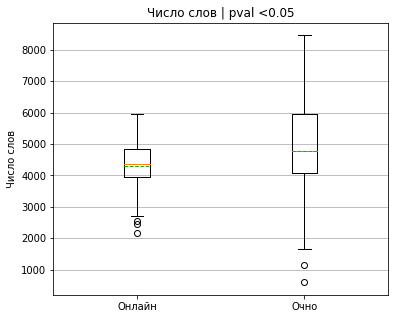

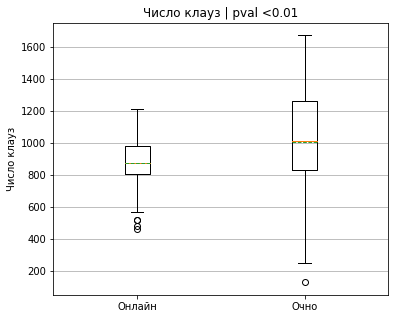

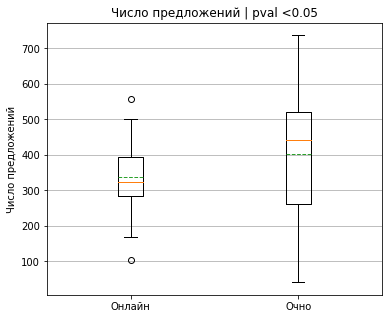

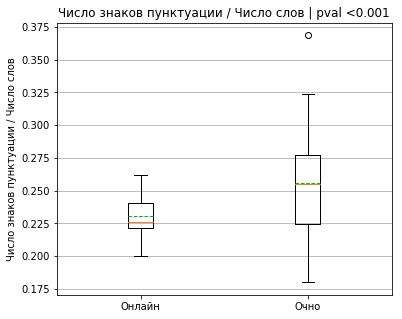

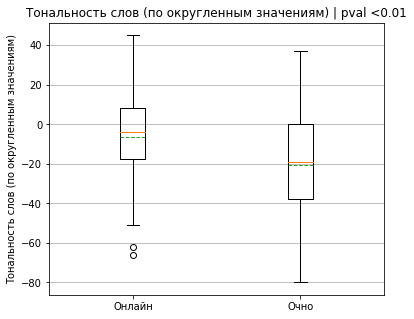

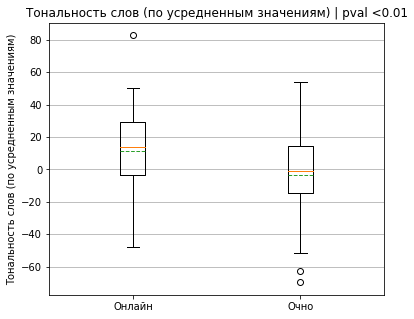

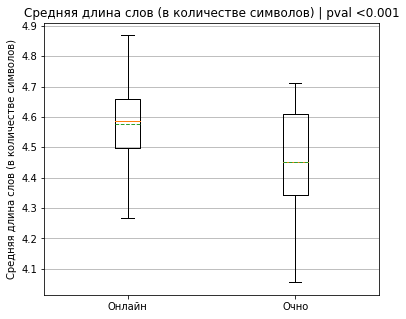

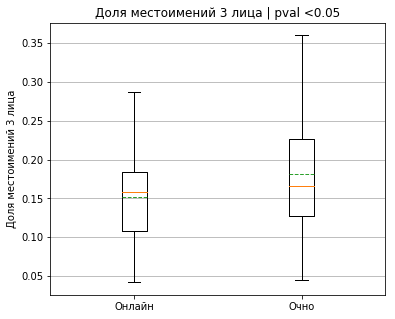

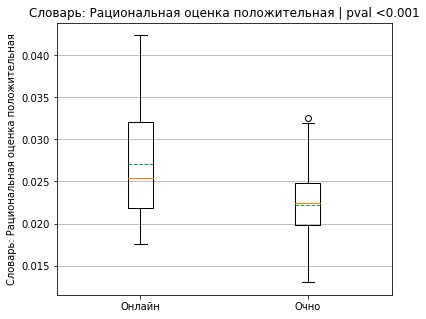

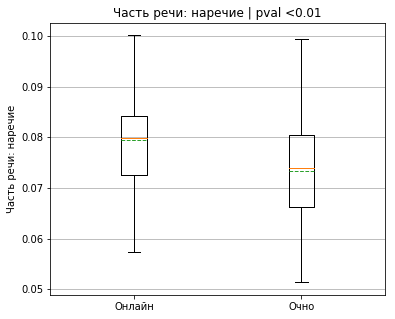

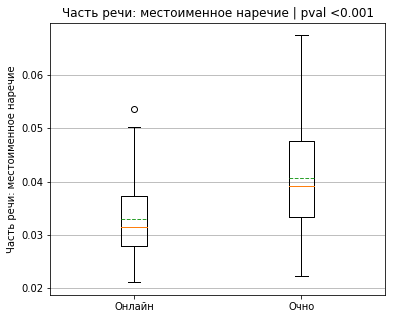

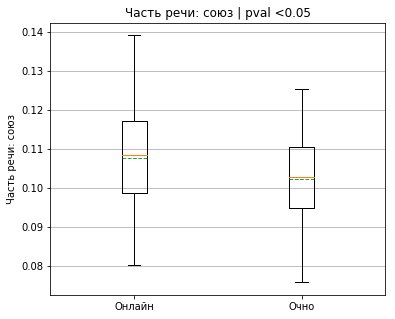

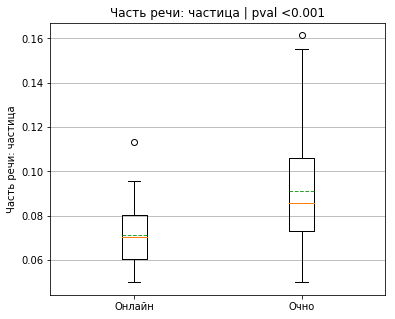

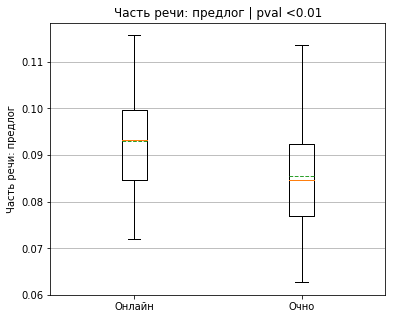

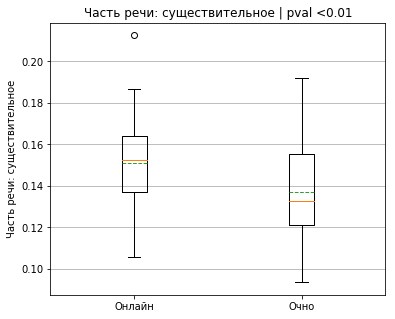

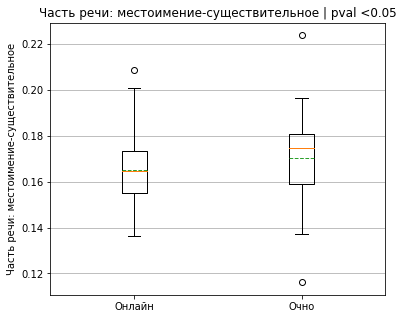

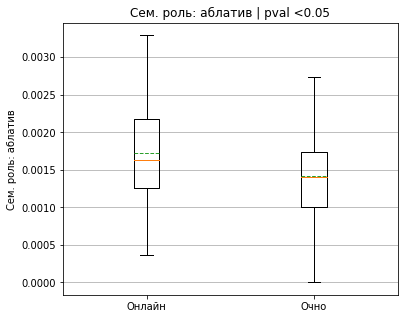

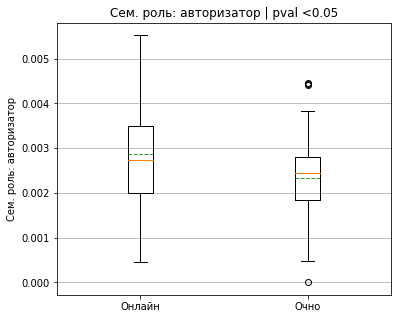

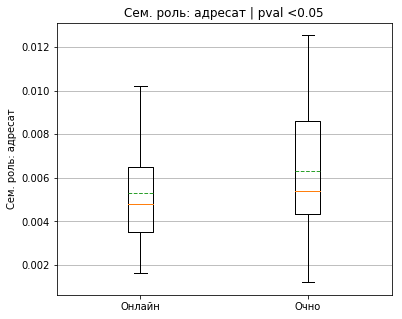

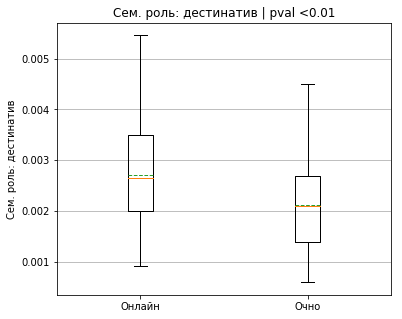

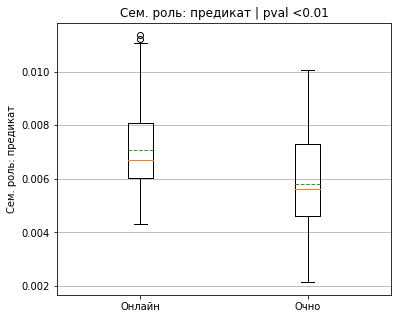

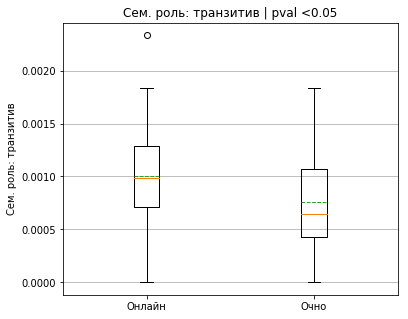

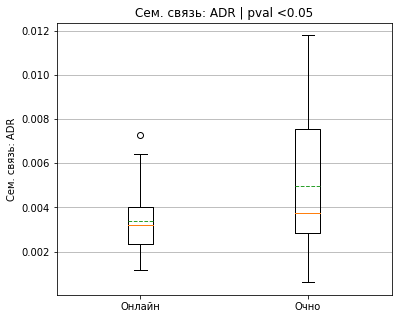

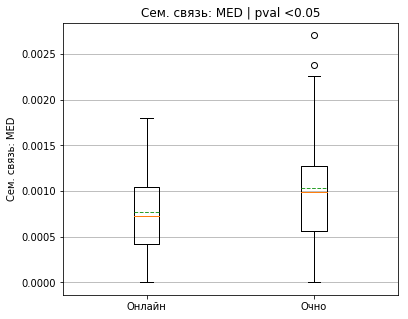

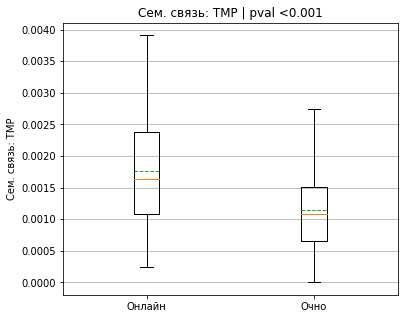

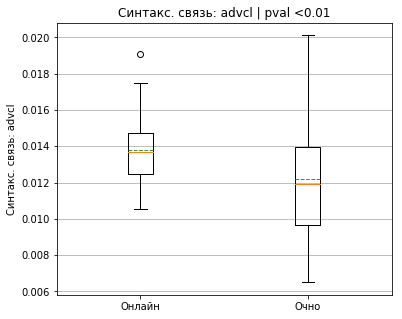

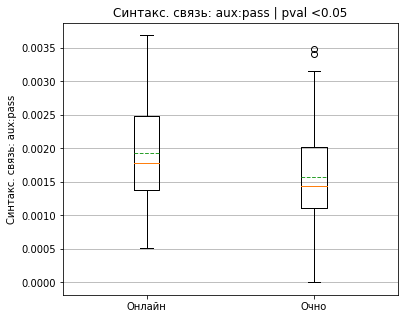

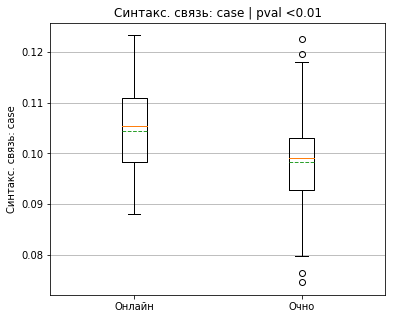

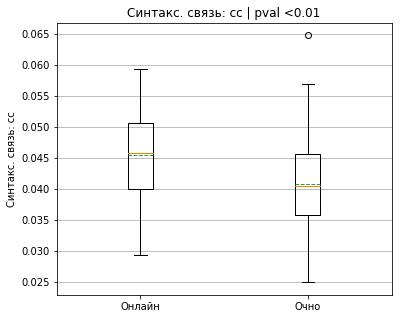

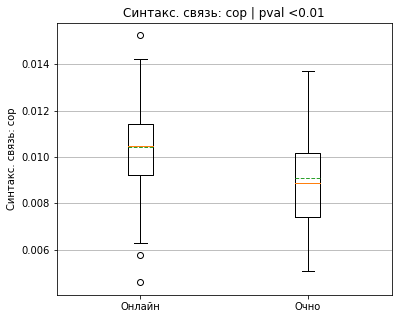

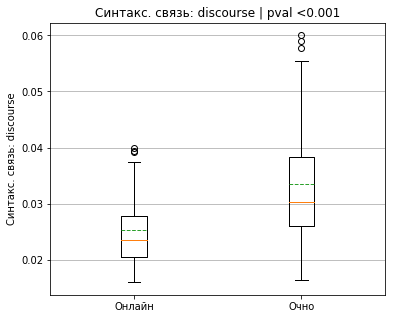

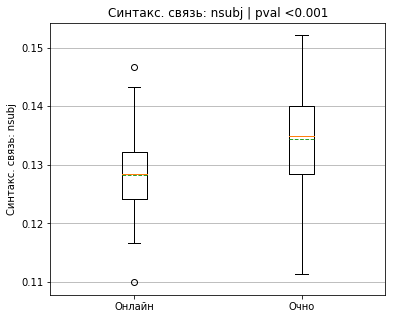

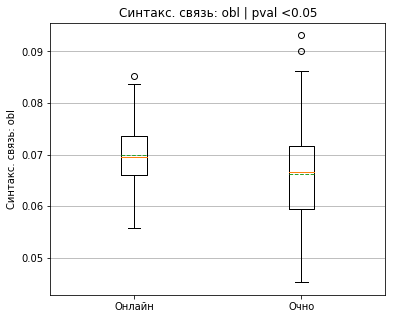

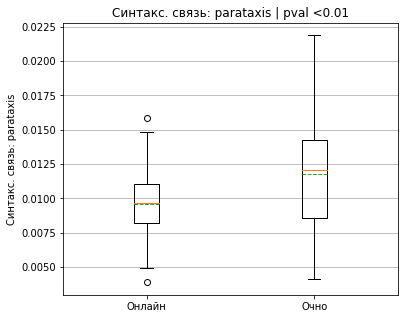

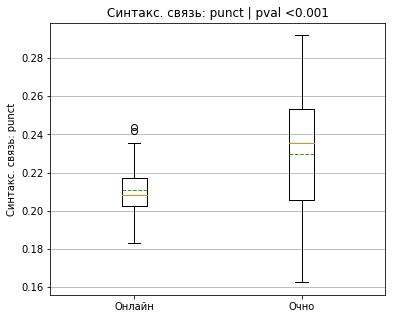

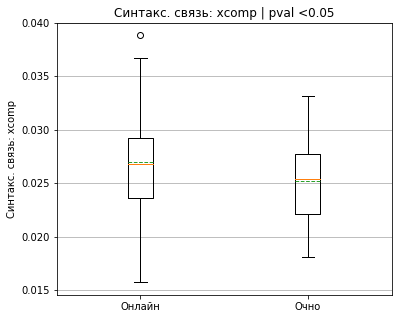

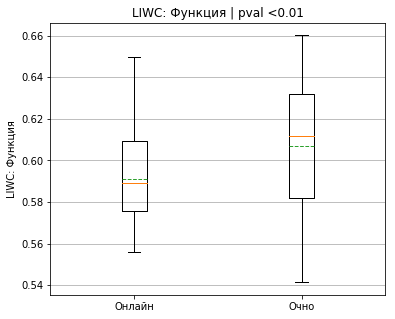

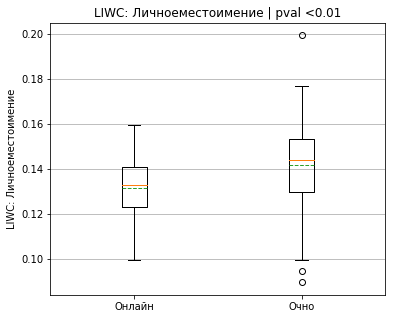

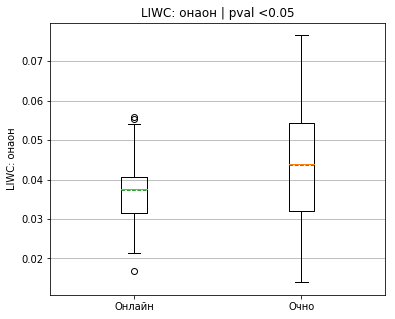

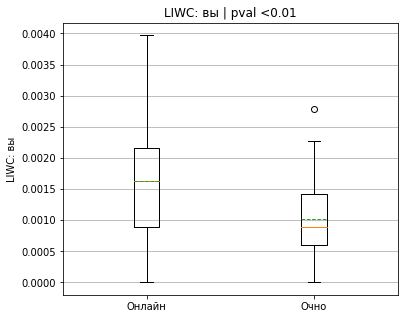

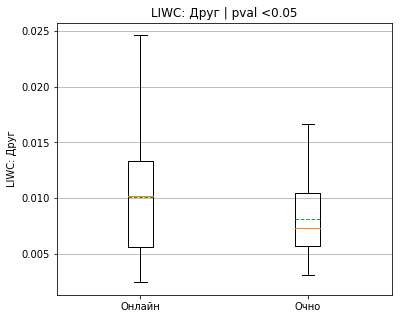

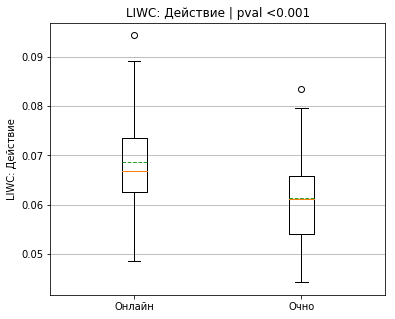

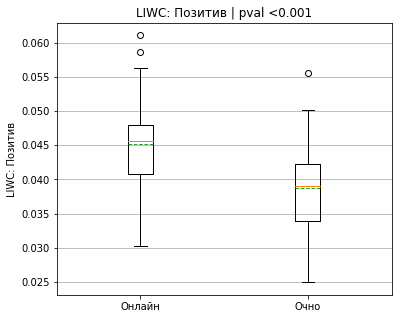

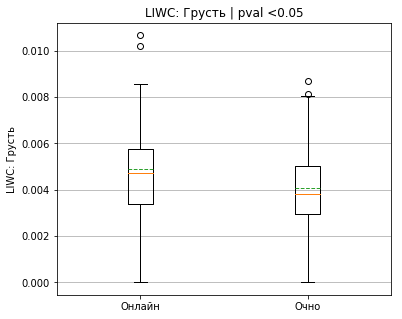

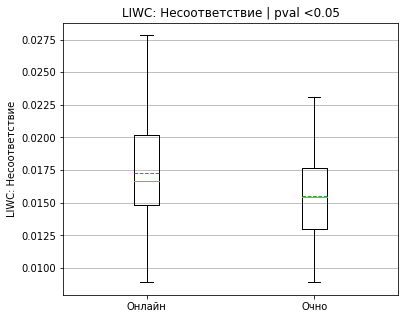

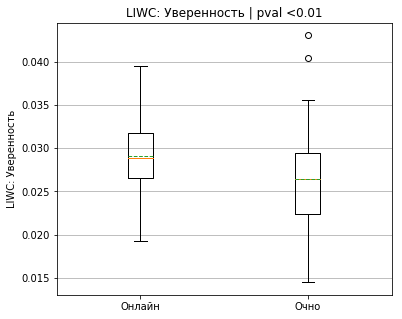

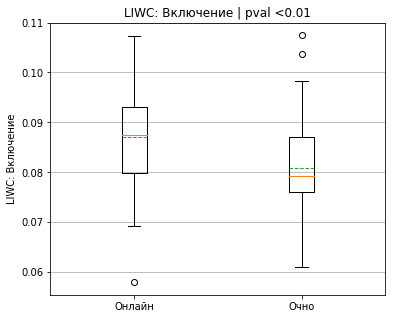

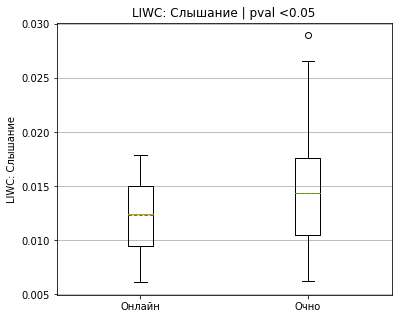

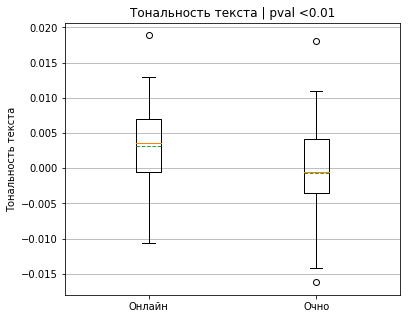

In [47]:
ignore_list = []
features_ignore = ['Доля прописных символов', 'Число знаков препинания']
stat_data = []
for feature in features:
    if feature not in features_ignore:
        target1 = remove_outliers(online[feature])
        target2 = remove_outliers(offline[feature])

        res = {}
        res['Показатель'] = feature
        res['Онлайн'] = 'Онлайн'
        res['Очно'] = 'Очно'
        res['Сред. Онлайн'] = target1.mean()
        res['Сред. Очно'] = target2.mean()
        res['pval mann-whitney'] = ''

        if normal_dist(target1) and normal_dist(target2):
            stat,pval = stats.mannwhitneyu(target1.tolist(),target2.tolist())
            if pval<0.05:
                res['pval mann-whitney'] = '<0.05'
                if pval<0.01:
                    res['pval mann-whitney'] = '<0.01'
                if pval<0.001:
                    res['pval mann-whitney'] = '<0.001'
                stat_data.append(res)
                boxplot(data_to_plot=[target1,target2], name1='Онлайн', name2='Очно', title=feature)

stat_df = pd.DataFrame(stat_data)
stat_df.sort_values(['pval mann-whitney'],ascending=True, inplace=True)

In [40]:
writer = pd.ExcelWriter('2 группы.xlsx', engine='xlsxwriter')
df_PM.to_excel(writer, sheet_name='Маркеры', index=False)
df_PM_abs.to_excel(writer, sheet_name='Маркеры (абсолютные значения)', index=False)
stat_df.to_excel(writer, sheet_name='Тест Манна-Уитни', index=False)
writer.save()